In [1]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import random
import pandas as pd

## Load embedding
Decide on big / small embedding to use for analysis

In [2]:
# You do not need to load both embeddings! For test runs, simply load the small embedding. It is much faster!
embeddings_dict = {}

In [3]:
# load big embedding into dictionary
# embedding from http://vectors.nlpl.eu/repository/
# English CoNLL17 corpus
# This takes a while!

# TODO: the binary file seems to be much smaller, maybe that can be used instead?

embeddings_dict_big = {}

counter = 0
errors = []
embeddings_dict = {}
with open("data/40/model.txt", 'r', encoding='ISO-8859-1') as f: # encoding needed for special characters
    for line in f:
        counter += 1
        values = line.split()
        word = values[0]
        try:
            vector = np.asarray(values[1:], "float32")
            embeddings_dict_big[word] = vector
        except:
            errors.append((counter, word)) # save words where the program breaks for some reason

# delete weird entries that have wrong dimensionality for some reason
liste = []
for k, v in embeddings_dict_big.items():
    if np.shape(v)[0] != 100:
        liste.append(k)

for w in liste:
    del embeddings_dict_big[w]
    
# del embeddings_dict["4027169"] # first line is weird

In [3]:
# ALTERNATIVELY: load smol embedding into dictionary
# this is the glove embedding from the authors of the paper
# corpus: wikipedia 2014 + gigaword
# https://nlp.stanford.edu/projects/glove/
embeddings_dict_smol = {}

with open("data/glove.6B.100d.txt", 'r') as f: 
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict_smol[word] = vector

In [4]:
# Choose embedding to work with

#embeddings_dict = embeddings_dict_smol
embeddings_dict = embeddings_dict_big

In [5]:
# random words option 1
# 2 x 50 random words to compare the companies against.
random_words_1 = "announcement friend ask pan tail quiet swarm calm glance level tolerate my part devote abortion memorial chaos bleed trench ensure mask create indulge salesperson conservative pier speculate genetic fiction regulation young harvest responsible beach squeeze seek field lip seasonal account complain angel dawn transport observation budge council sunshine farewell slide".split(" ")
random_words_2 = "healthy rage grain surprise trustee prison diagram promise shift escape amputate gallery note stress policeman edge foundation folk squeeze deck misery partnership distinct title hostage rate conspiracy sandwich abridge night old flourish crack angel example fibre urine courtship tragedy prove reform bush breakdown huge technology strip treat meal dignity wife".split(" ")
random_words = random_words_1 + random_words_2


In [6]:
# random words option 2
good_bad_words = "good bad great fantastic horrible worst nice best terrible hate love amazing cat dog".split(" ")
#random_keys = random.choices(list(embeddings_dict.keys()),k=10)

random_words = random_words_1[0:15] + good_bad_words[0:6]#random_keys + good_bad_words


### Helper functions

In [7]:
# function for finding closest words to one embedding
# warning : very slow!
# can be changed to spatial.distance.euclidean

def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.cosine(embeddings_dict[word], embedding))

In [8]:
# (returns angle between two vectors / lists / arrays)
# !! ATTENTION !! ->This function was changed to return cosine distance between two vectors!! (because jupyter sucks at renaming )
def angle_vec(vec1, vec2): 
    dot_product = np.dot(
        np.array(vec1) / np.linalg.norm(np.array(vec1)),
        np.array(vec2) / np.linalg.norm(np.array(vec2))
    )
    return 1 - dot_product #np.degrees(np.arccos(dot_product))

### Companies, frameworks and sentiment-words

In [9]:
companies = ["Google", "Microsoft", "amazon", "Facebook",
             "Intel", "Nvidia", "AMD", "Deepmind", "IBM",
             "Softbank ",
             "PAL",
             "Alibaba", "H20.ai", "Bosch",
             "SPHERO", "ANYBOTS", "sarcos", "BARRETT",
             "PETRONICS", "dronesense", "embodied",
             "energid" , "irobot", "myomo", "vecna"]

companies = [name.lower().replace(" ","") for name in companies]


frameworks = ["Sci-kit", "Tensorflow", "Theano", "Caffe", "Keras", "Torch", "MicrosoftCNTK",
             "OpenCV", "ROS", "OpenNN", "MxNet", "Amazon", "Matlab", "Accord.NET",
             "Spark","Mllib", "MLPack", "Apche", "Mahout", "Firebase", "Singa",
             "Azure", "Google", "H20", "YARP", "MRPT", "Gazebo",
             "OROCOS", "Spacy", "Facebook", "Gensim"]

frameworks = [name.lower().replace(" ","") for name in frameworks]

In [10]:
# view which companies are not in the embedding

for i in companies:
    try:
        embeddings_dict[i]
        print('%-15s%-15s' % (i, "True"))
    except:
        print('%-15s%-15s' % (i, "False"))
    # look at "printf-style String Formatting" in https://docs.python.org/3/library/stdtypes.html for info about nice formatting

google         True           
microsoft      True           
amazon         True           
facebook       True           
intel          True           
nvidia         True           
amd            True           
deepmind       True           
ibm            True           
softbank       True           
pal            True           
alibaba        True           
h20.ai         False          
bosch          True           
sphero         True           
anybots        True           
sarcos         True           
barrett        True           
petronics      False          
dronesense     False          
embodied       True           
energid        True           
irobot         True           
myomo          True           
vecna          True           


In [11]:
# view which frameworks are not in the embedding

for i in frameworks:
    try:
        embeddings_dict[i]
        print('%-15s%-15s' % (i, "True"))
    except:
        print('%-15s%-15s' % (i, "False"))

sci-kit        False          
tensorflow     True           
theano         True           
caffe          True           
keras          True           
torch          True           
microsoftcntk  False          
opencv         True           
ros            True           
opennn         True           
mxnet          False          
amazon         True           
matlab         True           
accord.net     True           
spark          True           
mllib          True           
mlpack         True           
apche          True           
mahout         True           
firebase       True           
singa          True           
azure          True           
google         True           
h20            True           
yarp           True           
mrpt           True           
gazebo         True           
orocos         True           
spacy          True           
facebook       True           
gensim         True           


In [12]:
# get embeddings simple positive and negative words

#positive_functional = "secure, safe, robust, reliable, trustworthy, efficient, interactive, user-friendly, maintained, stable, outperform, convenient, intelligent, automatic, automated".split(", ")
#negative_functional = "insecure, breach, slow, complicated, unstable".split(", ")
#positive_society = "famous, open-source, fair, ethical".split(", ")
#negative_society = "criticism, illegal, crime, fake, violate, unethical, biased, offensive".split(", ")
positive_functional = ["secure", "safe", "reliable", "simple", "fast", "stable", "intelligent", "convenient"]
negative_functional = ["insecure","unsafe","unreliable","complicated","slow","unstable","dumb","inconvenient"]

positive_society = ["good","famous","fair","legal","ethical","conform","praise","best"]
negative_society =["bad","unknown","biased","illegal","unethical","violate","criticism", "worst"]

# get embeddings for sentiment words
p_f_embed = []
for word in positive_functional:
    p_f_embed.append(embeddings_dict[word])

p_s_embed = []
for word in positive_society:
    p_s_embed.append(embeddings_dict[word])
    
n_f_embed = []
for word in negative_functional:
    n_f_embed.append(embeddings_dict[word])
    
n_s_embed = []
for word in negative_society:
    n_s_embed.append(embeddings_dict[word])

In [13]:
# get sentiment vectors from pairs of embeddings
# i.e. the embeddings of the "good -> bad" directions
# note that these are slightly different words than in the simple positive and negative embeddings

functional = [
    ("secure","insecure"),
    ("safe","unsafe"),
    ("reliable","unreliable"),
    ("simple", "complicated"),
    ("fast","slow"),
    ("stable","unstable"),
    ("intelligent","dumb"),
    ("convenient","inconvenient")
]
society = [
    ("good","bad"),
    ("famous","unknown"),
    ("fair","biased"),
    ("legal","illegal"),
    ("ethical","unethical"),
    ("conform","violate"),
    ("praise","criticism"),
    ("best", "worst"),
]

# get embeddings for sentiment words
functional_embed = []
for pair in functional:
    functional_embed.append(embeddings_dict[pair[1]] - embeddings_dict[pair[0]])

society_embed = []
for pair in society:
    society_embed.append(embeddings_dict[pair[1]] - embeddings_dict[pair[0]])

### 1st approach: Distances between companies and sentiment words

In [15]:
# for every element, returns average distance to the words in the list (as list)
# input: elements: list of words that may have bias
#        words: list of sentiment words that the elements may or may not be close to
# returns: 2D array [element, avg. dist to words]
def avg_dist(elements, words):
    output = []
    for elem in elements:
        dist = 0
        try:
            for word in words:
                dist += spatial.distance.cosine(embeddings_dict[elem], embeddings_dict[word])
            dist = dist / len(words)
        except: # elem not in vocabulary : do nothing
            dist = None
        output.append([elem, dist])
    return np.array(output)

In [16]:
# print average distance to sentiment words

p_f_comp = avg_dist(companies, positive_functional)
n_f_comp = avg_dist(companies, negative_functional)
p_s_comp = avg_dist(companies, positive_society)
n_s_comp = avg_dist(companies, negative_society)

p_f_frm = avg_dist(frameworks, positive_functional)
n_f_frm = avg_dist(frameworks, negative_functional)
p_s_frm = avg_dist(frameworks, positive_society)
n_s_frm = avg_dist(frameworks, negative_society)

# print values
#for c in range(len(companies)):
#    print("%-10s pos avg: %-10.6s neg avg: %-10.6s" % (p_f_comp[c][0], (p_f_comp[c][1] + p_s_comp[c][1])/2 , (n_f_comp[c][1] + n_s_comp[c][1])/2))
    # % = value, - = left align, 10 = distance or position, .6 = precision, s = converting to string

### Plot companies

In [17]:
# remove entries that are not in dataset
n_f_comp = n_f_comp[p_f_comp[:,1].astype(bool)]
p_s_comp = p_s_comp[p_f_comp[:,1].astype(bool)]
n_s_comp = n_s_comp[p_f_comp[:,1].astype(bool)]
p_f_comp = p_f_comp[p_f_comp[:,1].astype(bool)]

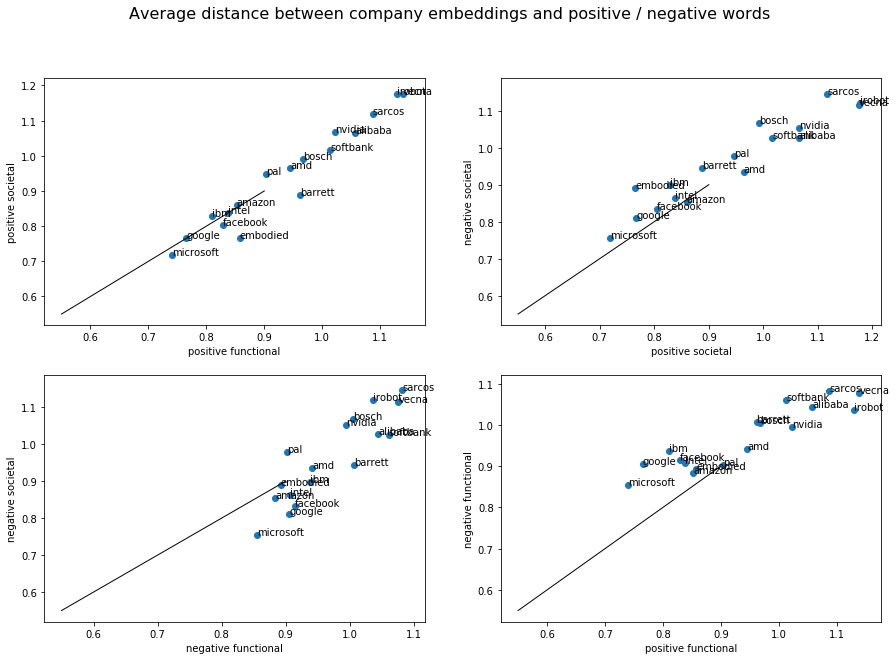

In [18]:
# plot distances of companies and positive / negative words
# the fact that there is a correlation is good:
# -> companies do not tend to be closer to negative words, than to positive words.
# -> if a company has a small distance to positive societal words, it also has a small distance to functional words
# however, companies like vecna seem to be polarising: they are associated with positive and negative words
# e.g. microsoft does not seem to be very polarising

# the black lines show where truly "neutral" companies would be. They are not regression lines!
line1 = 0.55
line2 = 0.9

fig, axes = plt.subplots(nrows=2, ncols=2)

fig.set_size_inches(15, 10)

fig.suptitle("Average distance between company embeddings and positive / negative words", fontsize=16)

axes[0,0].scatter(p_f_comp[:,1], p_s_comp[:,1])
axes[0,0].set(xlabel = "positive functional", ylabel = "positive societal")
for i, name in enumerate(p_f_comp[:,0]):
    axes[0,0].annotate(name, (p_f_comp[i,1], p_s_comp[i,1]))
axes[0,0].plot([line1, line2], [line1, line2], 'k-', lw=1)

axes[1,0].scatter(n_f_comp[:,1], n_s_comp[:,1])
axes[1,0].set(xlabel = "negative functional", ylabel = "negative societal")
for i, name in enumerate(p_f_comp[:,0]):
    axes[1,0].annotate(name, (n_f_comp[i,1], n_s_comp[i,1]))
axes[1,0].plot([line1, line2], [line1, line2], 'k-', lw=1)

axes[1,1].scatter(p_f_comp[:,1], n_f_comp[:,1])
axes[1,1].set(xlabel = "positive functional", ylabel = "negative functional")
for i, name in enumerate(p_f_comp[:,0]):
    axes[1,1].annotate(name, (p_f_comp[i,1], n_f_comp[i,1]))
axes[1,1].plot([line1, line2], [line1, line2], 'k-', lw=1)

axes[0,1].scatter(p_s_comp[:,1], n_s_comp[:,1])
axes[0,1].set(xlabel = "positive societal", ylabel = "negative societal")
for i, name in enumerate(p_f_comp[:,0]):
    axes[0,1].annotate(name, (p_s_comp[i,1], n_s_comp[i,1]))
axes[0,1].plot([line1, line2], [line1, line2], 'k-', lw=1)
#plt.savefig('distances_companies_w2v_cosine.pdf')

### Plot frameworks

In [19]:
# remove entries that are not in dataset
n_f_frm = n_f_frm[p_f_frm[:,1].astype(bool)]
p_s_frm = p_s_frm[p_f_frm[:,1].astype(bool)]
n_s_frm = n_s_frm[p_f_frm[:,1].astype(bool)]
p_f_frm = p_f_frm[p_f_frm[:,1].astype(bool)]

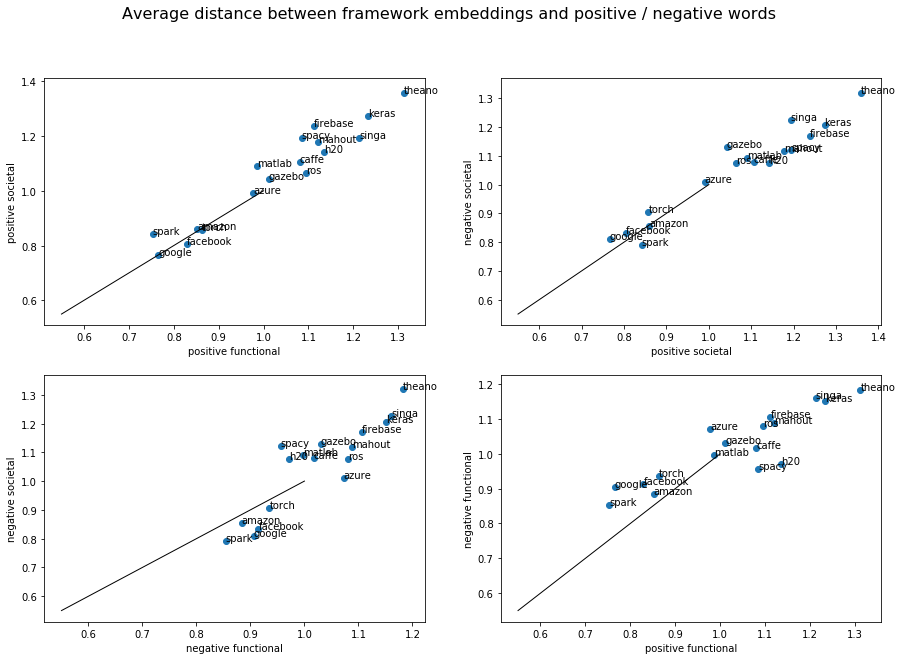

In [20]:
# plot distances of frameworks and positive / negative words
# the fact that there is a correlation is good:
# -> companies do not tend to be closer to negative words, than to positive words.
# -> if a company has a small distance to positive societal words, it also has a small distance to functional words
# however, companies like vecna seem to be polarising: they are associated with positive and negative words
# e.g. microsoft does not seem to be very polarising

# the black lines show where truly "neutral" companies would be. They are not regression lines!

line1 = 0.55
line2 = 1

fig, axes = plt.subplots(nrows=2, ncols=2)

fig.set_size_inches(15, 10)

fig.suptitle("Average distance between framework embeddings and positive / negative words", fontsize=16)

axes[0,0].scatter(p_f_frm[:,1], p_s_frm[:,1])
axes[0,0].set(xlabel = "positive functional", ylabel = "positive societal")
for i, name in enumerate(p_f_frm[:,0]):
    axes[0,0].annotate(name, (p_f_frm[i,1], p_s_frm[i,1]))
axes[0,0].plot([line1, line2], [line1, line2], 'k-', lw=1)

axes[1,0].scatter(n_f_frm[:,1], n_s_frm[:,1])
axes[1,0].set(xlabel = "negative functional", ylabel = "negative societal")
for i, name in enumerate(p_f_frm[:,0]):
    axes[1,0].annotate(name, (n_f_frm[i,1], n_s_frm[i,1]))
axes[1,0].plot([line1, line2], [line1, line2], 'k-', lw=1)

axes[1,1].scatter(p_f_frm[:,1], n_f_frm[:,1])
axes[1,1].set(xlabel = "positive functional", ylabel = "negative functional")
for i, name in enumerate(p_f_frm[:,0]):
    axes[1,1].annotate(name, (p_f_frm[i,1], n_f_frm[i,1]))
axes[1,1].plot([line1, line2], [line1, line2], 'k-', lw=1)

axes[0,1].scatter(p_s_frm[:,1], n_s_frm[:,1])
axes[0,1].set(xlabel = "positive societal", ylabel = "negative societal")
for i, name in enumerate(p_f_frm[:,0]):
    axes[0,1].annotate(name, (p_s_frm[i,1], n_s_frm[i,1]))
axes[0,1].plot([line1, line2], [line1, line2], 'k-', lw=1)
#plt.savefig('distances_frameworks_w2v_cosine.pdf')

### 2nd approach: Sentiment direction through PCA

#### Sentiment vectors as 1st PC of all sentiment words

This did not really work

#### Sentiment vectors as 1st PC of sentiment directions

In [28]:
# PCA from vectors of word pairs
# first PC of vectors of word pairs

pca2 = PCA(n_components=1)

principal_components2 = pca2.fit(functional_embed)
functional_sentiment_direction2 = principal_components2.components_[0]

principal_components2 = pca2.fit(society_embed)
society_sentiment_direction2 = principal_components2.components_[0]

#functional_sentiment_direction = embeddings_dict["broken"]
#society_sentiment_direction = embeddings_dict["perfect"]

In [29]:
# print and save all words with their angles to society words and functional words

angles_soc_func_frm_2 = []

for word in frameworks:
    try:
        #angles_soc_func.append((word, angle_vec(embeddings_dict[word], embeddings_dict["good"]), angle_vec(embeddings_dict[word], embeddings_dict["bad"])))
        angles_soc_func_frm_2.append((word, angle_vec(embeddings_dict[word], functional_sentiment_direction2), angle_vec(embeddings_dict[word], society_sentiment_direction2)))
    except:
        angles_soc_func_frm_2.append((word, None, None))

angles_soc_func_frm_2 = np.array(angles_soc_func_frm_2)

# filter out missing values
angles_soc_func_frm_2 = angles_soc_func_frm_2[angles_soc_func_frm_2[:,1] != np.array(None)]

In [30]:
# the same for companies

angles_soc_func_comp_2 = []

for word in companies:
    try:
        #angles_soc_func.append((word, angle_vec(embeddings_dict[word], embeddings_dict["good"]), angle_vec(embeddings_dict[word], embeddings_dict["bad"])))
        angles_soc_func_comp_2.append((word, angle_vec(embeddings_dict[word], functional_sentiment_direction2), angle_vec(embeddings_dict[word], society_sentiment_direction2)))
    except:
        angles_soc_func_comp_2.append((word, None, None))

angles_soc_func_comp_2 = np.array(angles_soc_func_comp_2)

# filter out missing values
angles_soc_func_comp_2 = angles_soc_func_comp_2[angles_soc_func_comp_2[:,1] != np.array(None)]

In [31]:
# print and save all random words with their angles to society words and functional words

angles_soc_func_random_2 = []

for word in random_words:
    angles_soc_func_random_2.append((word, angle_vec(embeddings_dict[word], functional_sentiment_direction2), angle_vec(embeddings_dict[word], society_sentiment_direction2)))
    
angles_soc_func_random_2 = np.array(angles_soc_func_random_2)
random_values_2 = angles_soc_func_random_2[:,1:3].astype(np.float) # it got converted to string for some reason?
random_names_2 = angles_soc_func_random_2[:,0]

In [32]:
# look at how much the angles differ to 90 degrees
# an angle of 90 degrees causes a cosine distance of 1
# this means that the words are indifferent to each other
# distances close to 0 mean that words are similar
# distances close to 2 mean that words are opposite

angles_soc_func_frm = np.array([[word[0], abs(1 - word[1]), abs(1 - word[2])] for word in angles_soc_func_frm_2], dtype='O')
angles_soc_func_comp = np.array([[word[0], abs(1 - word[1]), abs(1 - word[2])] for word in angles_soc_func_comp_2], dtype='O')
random_values = np.array([[abs(1 - word[0]), abs(1 - word[1])] for word in random_values_2])
random_names = random_words

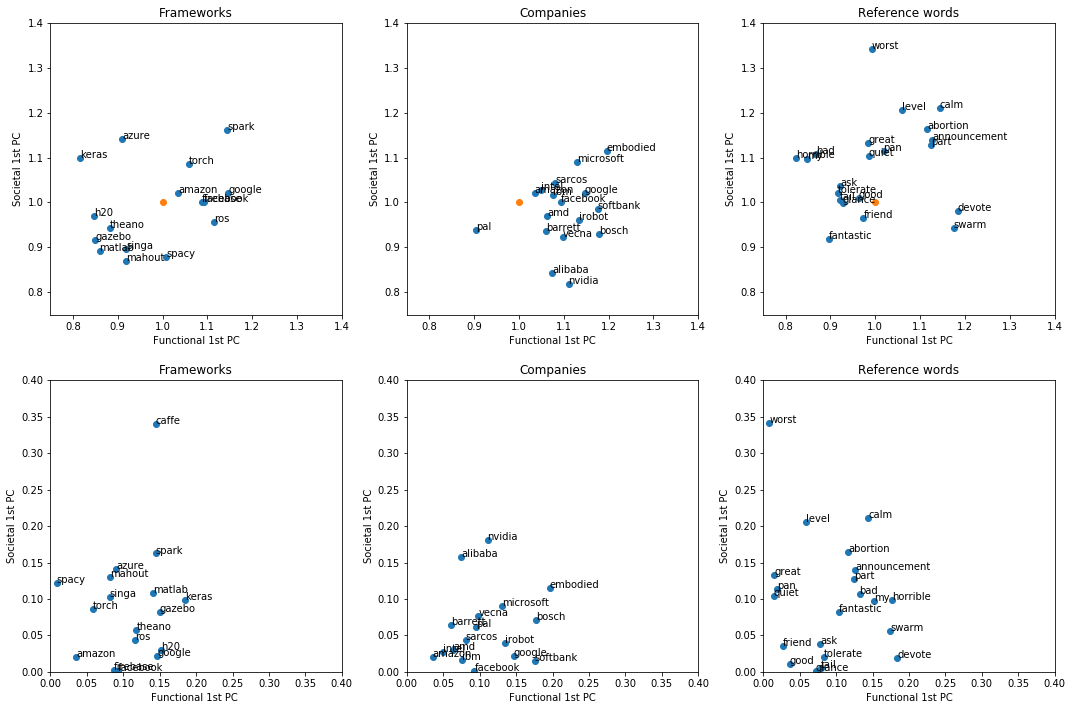

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=3)

fig.set_size_inches(15, 10)

#fig.suptitle("Cosine distance to sentiment directions, and how much they differ from 1.0 (neutral)", fontsize=16)

axes[1,0].scatter(angles_soc_func_frm[:,1], angles_soc_func_frm[:,2])
axes[1,0].set(xlabel = "Functional 1st PC ", ylabel="Societal 1st PC", title= "Frameworks")
for i, name in enumerate(angles_soc_func_frm[:,0]):
    axes[1,0].annotate(name, (angles_soc_func_frm[i,1], angles_soc_func_frm[i,2]))
    
axes[1,1].scatter(angles_soc_func_comp[:,1], angles_soc_func_comp[:,2])
axes[1,1].set(xlabel = "Functional 1st PC", ylabel="Societal 1st PC", title= "Companies")
for i, name in enumerate(angles_soc_func_comp[:,0]):
    axes[1,1].annotate(name, (angles_soc_func_comp[i,1], angles_soc_func_comp[i,2]))
    
axes[1,2].scatter(random_values[:,0], random_values[:,1])
axes[1,2].set(xlabel = "Functional 1st PC", ylabel="Societal 1st PC", title= "Reference words")
for i, name in enumerate(random_names):
    axes[1,2].annotate(name, (random_values[i,0], random_values[i,1]))
    
axes[0,0].scatter(angles_soc_func_frm_2[:,1], angles_soc_func_frm_2[:,2])
axes[0,0].set(xlabel = "Functional 1st PC", ylabel="Societal 1st PC", title= "Frameworks")
for i, name in enumerate(angles_soc_func_frm_2[:,0]):
    axes[0,0].annotate(name, (angles_soc_func_frm_2[i,1], angles_soc_func_frm_2[i,2]))
axes[0,0].scatter([1],[1])
    
axes[0,1].scatter(angles_soc_func_comp_2[:,1], angles_soc_func_comp_2[:,2])
axes[0,1].set(xlabel = "Functional 1st PC", ylabel="Societal 1st PC", title= "Companies")
for i, name in enumerate(angles_soc_func_comp_2[:,0]):
    axes[0,1].annotate(name, (angles_soc_func_comp_2[i,1], angles_soc_func_comp_2[i,2]))
axes[0,1].scatter([1],[1])
    
axes[0,2].scatter(random_values_2[:,0], random_values_2[:,1])
axes[0,2].set(xlabel = "Functional 1st PC", ylabel="Societal 1st PC", title= "Reference words")
for i, name in enumerate(random_names_2):
    axes[0,2].annotate(name, (random_values_2[i,0], random_values_2[i,1]))
axes[0,2].scatter([1],[1])

for ax in axes[0,:]:
    ax.set(xlim = [0.75, 1.4], ylim = [0.75, 1.4])
    ax.set_aspect('equal')
    
for ax in axes[1,:]:
    ax.set(xlim = [0, 0.4], ylim = [0, 0.4])
    ax.set_aspect('equal')
    
fig.tight_layout(rect=[0, 0, 1, 1])
#plt.savefig('sentiment_directions_GloVe_1.pdf')

## What does biased data look like?
Examples showcase biased words from the Paper "bias in word embeddings" by Papakyriakopoulos et. al

Text(0, 0.5, 'she')

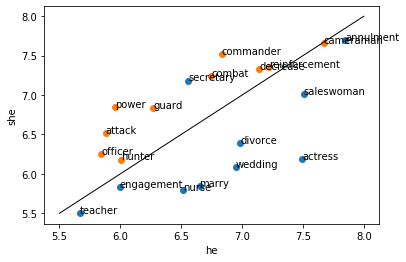

In [39]:
# bias as distances to the words "he" and "she"
# words that have a greater distance to "he" than to "she" (and vice versa) are biased
# the distance measure "euclidean" produces similar results

professions = ["secretary", "doctor", "nurse", "teacher", "officer", "hunter", "commander"]
manly_words = "Reinforcement Attack Combat Power Decrease Officer Hunter Commander Guard Cameraman".lower().split(" ")
womanly_words = "Nurse Secretary Teacher Saleswoman Actress Wedding Divorce Annulment Engagement Marry".lower().split(" ")


dist_he = np.array([spatial.distance.euclidean(embeddings_dict["he"], embeddings_dict[word]) for word in womanly_words])
dist_she = np.array([spatial.distance.euclidean(embeddings_dict["she"], embeddings_dict[word]) for word in womanly_words])
fig = plt.scatter(dist_he, dist_she)

for i, name in enumerate(womanly_words):
    plt.annotate(name, (dist_he[i], dist_she[i]))
#plt.plot([0.4,1], [0.4,1], 'k-', lw=1)

dist_he = np.array([spatial.distance.euclidean(embeddings_dict["he"], embeddings_dict[word]) for word in manly_words])
dist_she = np.array([spatial.distance.euclidean(embeddings_dict["she"], embeddings_dict[word]) for word in manly_words])
fig = plt.scatter(dist_he, dist_she)
for i, name in enumerate(manly_words):
    plt.annotate(name, (dist_he[i], dist_she[i]))
plt.plot([5.5,8], [5.5,8], 'k-', lw=1)
plt.xlabel("he")
plt.ylabel("she")
# womanly words are closer to the she - he vector
# manly words are closer to the he - she vector
#plt.savefig("gender_distances.pdf")

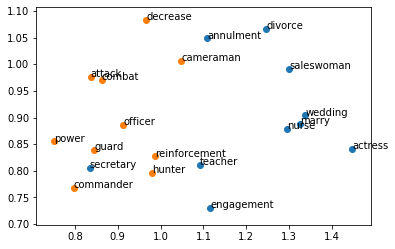

In [40]:
# in the context of sentiment vectors (he-she, good-bad, ...) a small distance seems to imply a bias towards that direction

professions = ["secretary", "doctor", "nurse", "teacher", "officer", "hunter", "commander"]
manly_words = "Reinforcement Attack Combat Power Decrease Officer Hunter Commander Guard Cameraman".lower().split(" ")
womanly_words = "Nurse Secretary Teacher Saleswoman Actress Wedding Divorce Annulment Engagement Marry".lower().split(" ")

dist_he = np.array([spatial.distance.cosine(embeddings_dict["he"]-embeddings_dict["she"], embeddings_dict[word]) for word in womanly_words])
dist_she = np.array([spatial.distance.cosine(embeddings_dict["good"]-embeddings_dict["bad"], embeddings_dict[word]) for word in womanly_words])
fig = plt.scatter(dist_he, dist_she)

for i, name in enumerate(womanly_words):
    plt.annotate(name, (dist_he[i], dist_she[i]))
#plt.plot([0.4,1], [0.4,1], 'k-', lw=1)

dist_he = np.array([spatial.distance.cosine(embeddings_dict["he"]-embeddings_dict["she"], embeddings_dict[word]) for word in manly_words])
dist_she = np.array([spatial.distance.cosine(embeddings_dict["good"]-embeddings_dict["bad"], embeddings_dict[word]) for word in manly_words])
fig = plt.scatter(dist_he, dist_she)
for i, name in enumerate(manly_words):
    plt.annotate(name, (dist_he[i], dist_she[i]))
#plt.plot([5.5,8], [5.5,8], 'k-', lw=1)

# womanly words are closer to the she - he vector
# manly words are closer to the he - she vector 

In [41]:
man_words = "man he male boy uncle grandfather queen dad".split(" ")
woman_words = "woman she female girl aunt grandmother king mom".split(" ")
gender_directions = [embeddings_dict[pair[1]] - embeddings_dict[pair[0]] for pair in zip(man_words, woman_words)]

pca = PCA(n_components=2)
gender_sentiment = pca.fit(gender_directions).components_

# cosine distance to first pc
manly_sentiment = [spatial.distance.cosine(gender_sentiment[0], embeddings_dict[word]) for word in manly_words]
womanly_sentiment = [spatial.distance.cosine(gender_sentiment[0], embeddings_dict[word]) for word in womanly_words]

# cosine distance to second pc
manly_sentiment1 = [spatial.distance.cosine(gender_sentiment[1], embeddings_dict[word]) for word in manly_words]
womanly_sentiment1 = [spatial.distance.cosine(gender_sentiment[1], embeddings_dict[word]) for word in womanly_words]

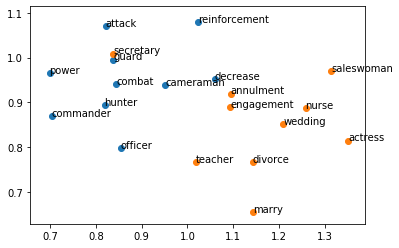

In [42]:
plt.scatter(manly_sentiment, manly_sentiment1)
plt.scatter(womanly_sentiment, womanly_sentiment1)
for i, name in enumerate(manly_words + womanly_words):
    plt.annotate(name, ((manly_sentiment + womanly_sentiment)[i], (manly_sentiment1 + womanly_sentiment1)[i]))

### other

In [43]:
# average absolute value of the distance between 90 degrees and the angle of the company vectors to the "society" direction
# measure of how biased the embedding is (between 0 and 90)

avg_societal_bias = 0
avg_functional_bias = 0
counter = 0

for line in angles_soc_func_random:
    angle_soc = line[2]
    angle_func = line[1]
    
    if angle_soc: # check if there is data for the company / framework
        counter += 1
        avg_societal_bias += abs(90 - angle_soc)
        avg_functional_bias += abs(90 - angle_func)
    
avg_functional_bias /= counter
avg_societal_bias /= counter

print("functional bias: ", avg_functional_bias, "societal bias: " , avg_societal_bias)
# CoNLL17: functional bias:  3.9495742106369267 societal bias:  11.044453649519795
# GloVe: functional bias:  5.988432694507943 societal bias:  7.173770563704972
# Random: functional bias:  9.304432622842576 societal bias:  10.992649064172603

NameError: name 'angles_soc_func_random' is not defined

## Training a classifier to predict sentiment

In [14]:
def findWord(embedding):
    pass
    dictionary = {'george': 16, 'amber': 19}
    search_age = input("Provide age")
    for name, age in dictionary.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
        if age == search_age:
            print(name)

In [15]:
# 4783 words
negative_words = []
negative_embed = []
with open("data/negative-words.txt", 'r', encoding='ISO-8859-1') as f: 
    for line in f:
        try:
            word = line.strip('\n')
            embed = embeddings_dict[word]
            negative_words.append(word)
            negative_embed.append(embed)
        except:
            pass

# 2006 words
positive_words = []
positive_embed = []
with open("data/positive-words.txt", 'r', encoding='ISO-8859-1') as f: 
    for line in f:
        try:
            word = line.strip('\n')
            embed = embeddings_dict[word]
            positive_words.append(word)
            positive_embed.append(embed)
        except:
            pass

In [44]:
# preprocess data
X = positive_embed + negative_embed
y = [1]*len(positive_embed) + [0]*len(negative_embed)

df = pd.DataFrame([X,y], dtype = float).T

# shuffle data
df = df.iloc[np.random.permutation(len(df))]
df = df.dropna()

# train test split
test = df[0:1000].to_numpy()
train = df[1000:len(df)].to_numpy()
test_index = df[0:1000].index.to_numpy()
train_index = df[1000:len(df)].to_numpy()

#test = test[~pd.isnull(test).any(axis=1)]
#train = train[~pd.isnull(train).any(axis=1)]
#test_index = test_index[~pd.isnull(test).any(axis=1)]
#train_index = train_index[~pd.isnull(train).any(axis=1)]

# filter out names that are not in embedding
frm_names = [frm for frm in frameworks if frm in embeddings_dict]
comp_names = [comp for comp in companies if comp in embeddings_dict]

In [45]:
# Logistic regression

logistic_model = LogisticRegression(solver='lbfgs')
logistic_model.fit(list(train[:,0]), list(train[:,1]))
logistic_model.score(list(test[:,0]), list(test[:,1]))

0.929

In [46]:
# predictions

frm_logistic = np.array([logistic_model.predict_proba(embeddings_dict[frm].reshape(1, -1))[0,1] for frm in frameworks if frm in embeddings_dict])
#frm_logistic = list(frm_logistic[:,:,0][:,0])

comp_logistic = np.array([logistic_model.predict_proba(embeddings_dict[comp].reshape(1, -1))[0,1] for comp in companies if comp in embeddings_dict])
#comp_logistic = list(comp_logistic[:,:,0][:,0])

In [47]:
# Naive Bayes

bayes_model = GaussianNB()
bayes_model.fit(list(train[:,0]), list(train[:,1]))
bayes_model.score(list(test[:,0]), list(test[:,1]))

0.885

In [49]:
# predictions

frm_bayes = np.array([bayes_model.predict_proba(embeddings_dict[frm].reshape(1, -1))[0,1] for frm in frameworks if frm in embeddings_dict])
#frm_bayes = list(frm_bayes[:,:,0][:,0])

comp_bayes = np.array([bayes_model.predict_proba(embeddings_dict[comp].reshape(1, -1))[0,1] for comp in companies if comp in embeddings_dict])
#comp_bayes = list(comp_bayes[:,:,0][:,0])

In [50]:
bayes_model.predict_proba(embeddings_dict["test"].reshape(1,-1))[0,1]

0.8441518855600203

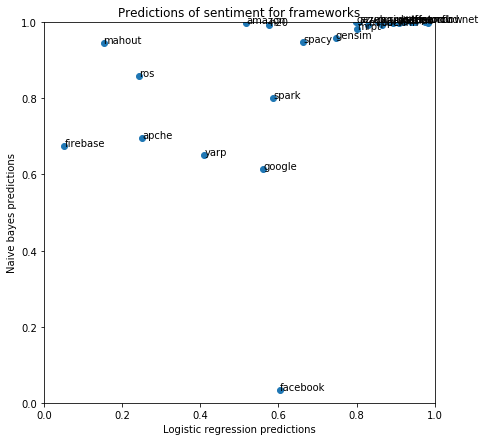

In [51]:
# plot logistic prediction against bayes prediction

fig = plt.scatter(frm_logistic, frm_bayes)
plt.title("Predictions of sentiment for frameworks")
plt.rcParams["figure.figsize"] = (7,7)
plt.xlabel("Logistic regression predictions")
plt.ylabel("Naive bayes predictions")
plt.xlim((0,1))
plt.ylim((0,1))
for i, name in enumerate(frm_names):
    plt.annotate(name, (frm_logistic[i], frm_bayes[i]))
#plt.savefig("predictions_frameworks_Word2Vec.pdf")

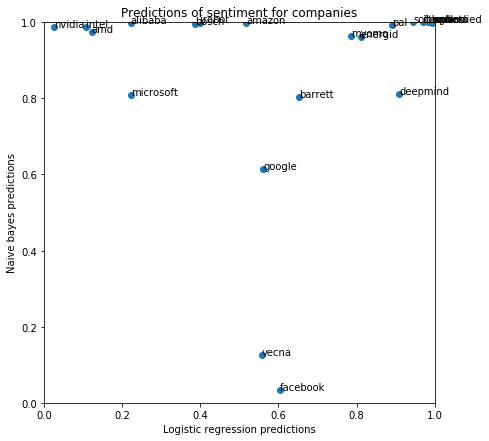

In [52]:
fig = plt.scatter(comp_logistic, comp_bayes)
plt.title("Predictions of sentiment for companies")
plt.rcParams["figure.figsize"] = (7,7)
plt.xlabel("Logistic regression predictions")
plt.ylabel("Naive bayes predictions")
plt.xlim((0,1))
plt.ylim((0,1))
for i, name in enumerate(comp_names):
    plt.annotate(name, (comp_logistic[i], comp_bayes[i]))
#plt.savefig("predictions_companies_Word2Vec.pdf")

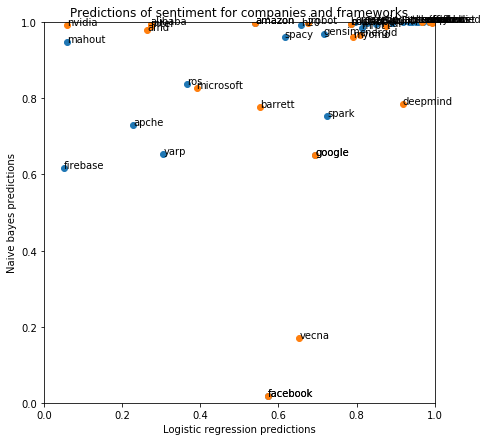

In [31]:
fig = plt.scatter(frm_logistic, frm_bayes)
plt.title("Predictions of sentiment for frameworks")
plt.rcParams["figure.figsize"] = (7,7)
plt.xlabel("Logistic regression predictions")
plt.ylabel("Naive bayes predictions")
plt.xlim((0,1))
plt.ylim((0,1))
for i, name in enumerate(frm_names):
    plt.annotate(name, (frm_logistic[i], frm_bayes[i]))
    
fig = plt.scatter(comp_logistic, comp_bayes)
plt.title("Predictions of sentiment for companies and frameworks")
plt.rcParams["figure.figsize"] = (7,7)
plt.xlabel("Logistic regression predictions")
plt.ylabel("Naive bayes predictions")
plt.xlim((0,1))
plt.ylim((0,1))
for i, name in enumerate(comp_names):
    plt.annotate(name, (comp_logistic[i], comp_bayes[i]))
#plt.savefig("prediction of sentiment bigEmbedding")

In [33]:
print(bayes_model.predict_proba(embeddings_dict["facebook"].reshape(1, -1)))
print(logistic_model.predict_proba(embeddings_dict["facebook"].reshape(1, -1)))

[[0.98293399 0.01706601]]
[[0.42705822 0.57294178]]


In [26]:
test_p = test[test[:,1] == 1]
test_n = test[test[:,1] == 0]

In [ ]:
test[test[:,0] == 1]
logistic_model.predict_proba(list(test[:,0]))[:,1]

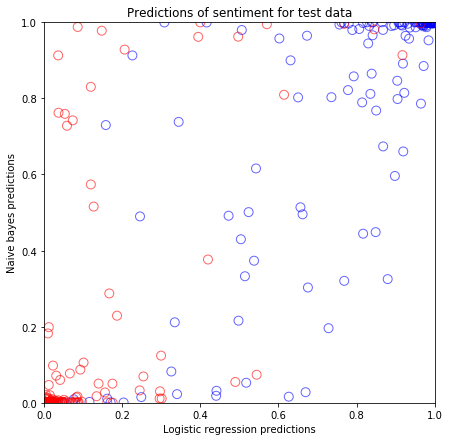

In [74]:
fig = plt.scatter(logistic_model.predict_proba(list(test_p[:,0])[0:200])[:,1], bayes_model.predict_proba(list(test_p[:,0])[0:200])[:,1], s=80, facecolors='none', edgecolors='b', alpha = 0.6)
plt.title("Predictions of sentiment for test data")
plt.rcParams["figure.figsize"] = (7,7)
plt.xlabel("Logistic regression predictions")
plt.ylabel("Naive bayes predictions")
plt.xlim((0,1))
plt.ylim((0,1))
fig = plt.scatter(logistic_model.predict_proba(list(test_n[:,0])[0:200])[:,1], bayes_model.predict_proba(list(test_n[:,0])[0:200])[:,1], s=80, facecolors='none', edgecolors='r',alpha = 0.6)

#for i, name in enumerate([embeddings_dict[df.loc[word][0]] for word in test_index]): 
#    plt.annotate(name, (comp_logistic[i], comp_bayes[i]))
#for i, name in enumerate(comp_names):
#    plt.annotate(name, (comp_logistic[i], comp_bayes[i]))
#plt.savefig("prediction_test_Word2Vec.pdf")

In [38]:
#pd.DataFrame(frm_logistic).plot(kind="density", bw_method = 0.1, xlim = (0,1))
#pd.DataFrame(comp_logistic).plot(kind="density", bw_method = 0.1, xlim=(0,1))

array([array([ 0.051757, -0.150678,  0.135471, -0.292184,  0.178925, -0.006122,
       -0.193963, -0.049246, -0.392125, -0.064063, -0.087524,  0.30131 ,
        0.050282,  0.269974, -0.147316,  0.169817, -0.173879,  0.019117,
        0.372623,  0.534941,  0.535887, -0.183387, -0.057706, -0.489186,
       -0.146491, -0.523574, -0.093555, -0.364166,  0.18712 , -0.18196 ,
       -0.233508,  0.337036, -0.4313  ,  0.003993, -0.400137, -0.133665,
       -0.11623 ,  0.04542 , -0.041039, -0.568545, -0.499669,  0.03353 ,
       -0.02106 ,  0.103674,  0.346719,  0.428199,  0.304961,  0.166899,
       -0.174038, -0.101514, -0.093902,  0.008451,  0.035325,  0.250893,
       -0.198995,  0.077423,  0.235622,  0.263599, -0.388072, -0.253279,
       -0.516909, -0.334131, -0.172254, -0.126495,  0.037693, -0.387462,
       -0.114483,  0.139868,  0.088795, -0.123531,  0.123638, -0.182949,
        0.056116, -0.588969,  0.005245,  0.21393 , -0.45217 , -0.062536,
       -0.20943 , -0.237688,  0.073044,  0.1

In [71]:
print(np.mean(list(logistic_model.predict_proba(list(test[:,0]))[:,1])))
np.mean(list(bayes_model.predict_proba(list(test[:,0]))[:,1]))

0.30334954732657954


0.3156447540665242

In [72]:
np.std(list(frm_logistic)+list(frm_bayes))

0.2560229876875511

In [73]:
np.std(list(comp_logistic)+list(comp_bayes))

0.32127403860579806